### Task 2 Question 1:
Image Reconstruction - Choose any image you like. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from the image coordinates (X, Y) to the pixel colors (R, G, B). Here, (X, Y) represents the coordinates of the pixels, and (R, G, B) represents the color values at those coordinates. Display both the original image and the reconstructed image. Also, calculate and report the Root Mean Squared Error (MSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images. **[1.5 Mark]**


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import sklearn
from einops import rearrange
import matplotlib.gridspec as gridspec

In [2]:
img = torchvision.io.read_image("./pic.jpg")
img.max(), img.min(), img.shape

(tensor(255, dtype=torch.uint8),
 tensor(0, dtype=torch.uint8),
 torch.Size([3, 1846, 2685]))

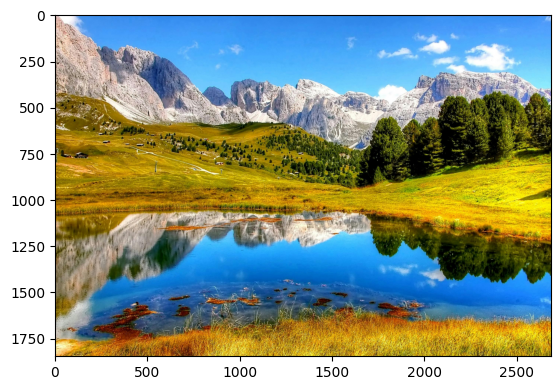

In [3]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [4]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [5]:
scaled_img = scaler_img.transform(img.reshape(-1,1)).reshape(img.shape)
scaled_img.max(), scaled_img.min(), scaled_img.shape

(np.float64(1.0), np.float64(0.0), (3, 1846, 2685))

In [6]:
scaled_img = torch.tensor(scaled_img)

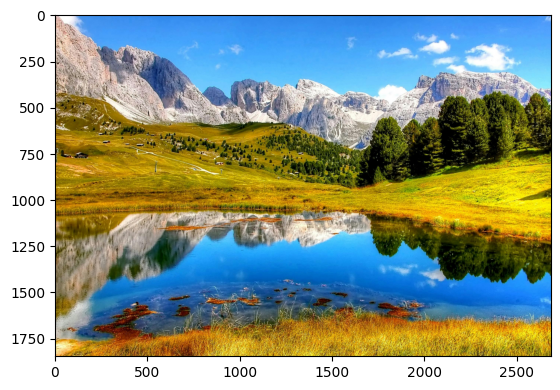

In [7]:
plt.imshow(rearrange(scaled_img, 'c h w -> h w c'))

In [8]:
crop = torchvision.transforms.functional.crop(scaled_img, 1000, 1000, 300, 300)
crop.shape

torch.Size([3, 300, 300])

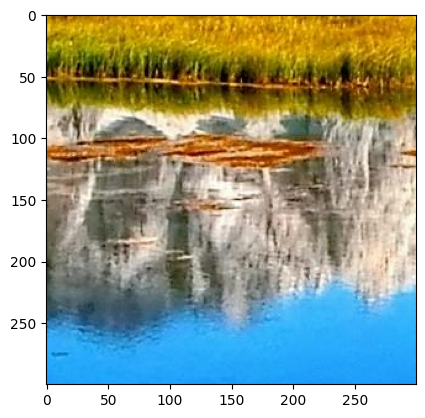

In [9]:
plt.imshow(rearrange(crop, 'c h w -> h w c'))

In [10]:
def create_coordinate_map(img):

    num_channels, height, width = img.shape

    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1)

    Y = rearrange(img, 'c h w -> (h w) c')
    return X, Y

In [11]:
img_X, img_Y = create_coordinate_map(crop)
img_X.shape,  img_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [12]:
img_Y.max(), img_Y.min()

(tensor(1., dtype=torch.float64), tensor(0., dtype=torch.float64))

In [13]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(img_X)

img_X_scaled = scaler_X.transform(img_X)

img_X_scaled = torch.tensor(img_X_scaled)

In [14]:
img_X_scaled.max(), img_X_scaled.min()

(tensor(1., dtype=torch.float64), tensor(-1., dtype=torch.float64))

In [15]:
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = rff.fit_transform(X)
    return X

In [31]:
X_rff = create_rff_features(img_X_scaled, 20000, 0.008)

In [32]:
X_rff.shape

(90000, 20000)

In [18]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [19]:
def train(net, lr, X, Y, epochs, verbose=True):

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)

        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [20]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):

    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)

    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs)
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")

    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [33]:
X_rff_tensor = torch.tensor(X_rff, dtype=torch.float32)
img_Y_tensor = torch.tensor(img_Y, dtype=torch.float32)

C:\Users\Vansh\AppData\Local\Temp\ipykernel_18336\234945123.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_Y_tensor = torch.tensor(img_Y, dtype=torch.float32)


In [34]:
net = LinearModel(X_rff_tensor.shape[1], 3)

train(net, 0.05, X_rff_tensor, img_Y_tensor, 1000)

Epoch 0 loss: 0.345413
Epoch 100 loss: 0.009756
Epoch 200 loss: 0.002902
Epoch 300 loss: 0.001570
Epoch 400 loss: 0.001343
Epoch 500 loss: 0.001295
Epoch 600 loss: 0.001273
Epoch 700 loss: 0.001259
Epoch 800 loss: 0.001249
Epoch 900 loss: 0.001242


0.0012362023117020726

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24235977..1.3265908].


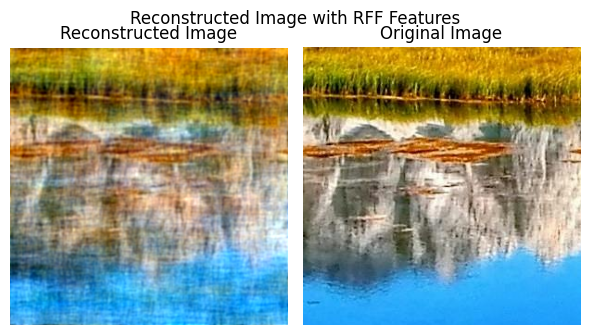

In [30]:
plot_reconstructed_and_original_image(crop, net, X_rff_tensor, title="Reconstructed Image with RFF Features")

In [24]:
with torch.no_grad():
    net.eval()
    reconstructed_image = net(X_rff_tensor)
    reconstructed_image = reconstructed_image.reshape(crop.shape[1], crop.shape[2], crop.shape[0])

In [25]:
def calculate_rmse(original, reconstructed):

    original = original.numpy()
    reconstructed = reconstructed.numpy()

    mse = np.mean((original - reconstructed) ** 2)
    rmse = np.sqrt(mse)
    return rmse

In [26]:
def calculate_psnr(original, reconstructed):

    original = original.numpy()
    reconstructed = reconstructed.numpy()

    mse = np.mean((original - reconstructed) ** 2)
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [27]:
rmse = calculate_rmse(crop, reconstructed_image.permute(2, 0, 1))
psnr = calculate_psnr(crop, reconstructed_image.permute(2, 0, 1))

In [28]:
print(rmse,"\n", psnr)

0.10252104359313455 
 19.783739632972235
